# Comparing seqFISH reported burst sizes to *biVI* inferences on Desai 10x scRNA-seq data


Desai data is also in mouse embryonic stem cells (though a different strain). Do gene parameter trends hold? 



In [1]:
# System
import sys
sys.path.insert(0, '../../BIVI')


import importlib

import numpy as np
import torch
import pandas as pd
import pickle
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
from collections import Counter

# colors
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# single cell
import anndata
import scanpy as sc

# import biVI scripts
import biVI

Global seed set to 0
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
# load in data
def nd(input_matrix):
    return(np.array(input_matrix).flatten())


def get_MoM_burstsize(intron_mean,intron_var):
    '''Returns method of moment estimate for burst size given array of nascent/intron counts in format
     cell by gene. Returns array of length(# genes).'''
 
    burstsize_array = (intron_var-intron_mean)/intron_mean
    
    return(burstsize_array)


In [64]:
# load in data from seqFISH
with open('../results/E14_rep1_seqFISH_burst_sizes_all','rb') as file:
    es_rep1_all = pickle.load(file)
with open('../results/E14_rep2_seqFISH_burst_sizes_all','rb') as file:
    es_rep2_all = pickle.load(file)

    
with open('../results/E14_rep1_seqFISH_biVI_parameters_adj_introns_subset','rb') as file:
    es_rep1_subset_adj = pickle.load(file)
with open('../results/E14_rep2_seqFISH_biVI_parameters_adj_introns_subset','rb') as file:
    es_rep2_subset_adj = pickle.load(file)
    
    
with open('../results/E14_rep1_seqFISH_biVI_parameters_raw_introns_subset','rb') as file:
    es_rep1_subset = pickle.load(file)
with open('../results/E14_rep2_seqFISH_biVI_parameters_raw_introns_subset','rb') as file:
    es_rep2_subset = pickle.load(file)
    

In [66]:
# create nice data frames of seqFISH data

es_rep1_df_all = pd.DataFrame({
    'gene_name' : es_rep1_all['gene_name'],
    'burst_size' : es_rep1_all['burst_size'].mean(axis=0),
    'burst_size_variance' : es_rep1_all['burst_size'].var(axis=0)
})

es_rep2_df_all = pd.DataFrame({
    'gene_name' : es_rep2_all['gene_name'],
    'burst_size' : es_rep2_all['burst_size'].mean(axis=0),
    'burst_size_variance' : es_rep2_all['burst_size'].var(axis=0)
})

es_rep1_df_subset = pd.DataFrame({
    'gene_name' : es_rep1_subset['gene_name'],
    'burst_size' : es_rep1_subset['seqFISH_burst_size'][0].mean(axis=0),
    'burst_size_variance' : es_rep1_subset['seqFISH_burst_size'][0].var(axis=0),
    'mean_intron_counts' : es_rep1_subset['intron_counts'].mean(axis=0),
    'mean_adj_intron_counts' : es_rep1_subset_adj['intron_counts'].mean(axis=0),
    'mean_exon_counts' : es_rep1_subset['exon_counts'].mean(axis=0)
})

es_rep2_df_subset = pd.DataFrame({
    'gene_name' : es_rep2_subset['gene_name'],
    'burst_size' : es_rep2_subset['seqFISH_burst_size'][0].mean(axis=0),
    'burst_size_variance' : es_rep2_subset['seqFISH_burst_size'][0].var(axis=0),
    'mean_intron_counts' : es_rep2_subset['intron_counts'].mean(axis=0),
    'mean_adj_intron_counts' : es_rep2_subset_adj['intron_counts'].mean(axis=0),
    'mean_exon_counts' : es_rep2_subset['exon_counts'].mean(axis=0)
})

In [67]:
# load in adata and subset to ONLY unique genes and those genes that were in es_rep2

adata = anndata.read_loom('../data/desai/desai_dmso.loom')
unique_elements, counts = np.unique(adata.var['gene_name'].values, return_counts=True)
unique_genes = unique_elements[np.where(counts == 1)[0]]
adata = adata[:,adata.var['gene_name'].isin(unique_genes)]

# add enseml id stripped column
adata.var['ensembl_id_stripped'] = [id_.split('.')[0] for id_ in adata.var['gene_id'].values]


# then subset to only genes in e14 rep1
adata = adata[:,adata.var['gene_name'].isin(es_rep2_all['gene_name'])]

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
<ipython-input-67-ae122144c29e>:9: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id_stripped'] = [id_.split('.')[0] for id_ in adata.var['gene_id'].values]


In [68]:
# create nice data frame from adata counts

adata_df_all = pd.DataFrame({'gene_name': adata.var['gene_name'].values,
                         'ensembl_id_stripped': adata.var['ensembl_id_stripped'].values,
                         'mean_unspliced_counts' : nd(adata.layers['unspliced'].mean(axis=0)),
                         'mean_spliced_counts' : nd(adata.layers['spliced'].mean(axis=0)),
#                          'MoM_burst_size' : get_MoM_burstsize(
#                                          nd(adata.layers['unspliced'].mean(axis=0)),
#                                          np.array(adata.layers['unspliced'].todense()).var(axis=0)) 
                                       })


adata_df_subset = pd.DataFrame({'gene_name': adata.var['gene_name'].values,
                         'ensembl_id_stripped': adata.var['ensembl_id_stripped'].values,
                         'mean_unspliced_counts' : nd(adata.layers['unspliced'].mean(axis=0)),
                         'mean_spliced_counts' : nd(adata.layers['spliced'].mean(axis=0)),
#                          'MoM_burst_size' : get_MoM_burstsize(
#                                          nd(adata.layers['unspliced'].mean(axis=0)),
#                                          np.array(adata.layers['unspliced'].todense()).var(axis=0)) 
                                       })

In [69]:
# filter the dataframes so they all have the same genes
adata_df_all['gene_name_cat'] = pd.Categorical(
    adata_df_all['gene_name'], 
    categories=np.sort(es_rep1_df_all['gene_name'].values), 
    ordered=True
)
adata_df_all = adata_df_all.sort_values('gene_name_cat').dropna()

es_rep1_df_all['gene_name_cat'] = pd.Categorical(
    es_rep1_df_all['gene_name'], 
    categories=np.sort(adata_df_all['gene_name'].values), 
    ordered=True
)


es_rep2_df_all['gene_name_cat'] = pd.Categorical(
    es_rep2_df_all['gene_name'], 
    categories=np.sort(adata_df_all['gene_name'].values), 
    ordered=True
)



es_rep1_df_all  = es_rep1_df_all.sort_values('gene_name_cat').dropna()
es_rep2_df_all  = es_rep2_df_all.sort_values('gene_name_cat').dropna()


# same for subset
adata_df_subset['gene_name_cat'] = pd.Categorical(
    adata_df_subset['gene_name'], 
    categories=np.sort(es_rep1_df_subset['gene_name'].values), 
    ordered=True
)

adata_df_subset = adata_df_subset.sort_values('gene_name_cat').dropna()

es_rep1_df_subset['gene_name_cat'] = pd.Categorical(
    es_rep1_df_subset['gene_name'], 
    categories=np.sort(adata_df_subset['gene_name'].values), 
    ordered=True
)


es_rep2_df_subset['gene_name_cat'] = pd.Categorical(
    es_rep2_df_subset['gene_name'], 
    categories=np.sort(adata_df_subset['gene_name'].values), 
    ordered=True
)



es_rep1_df_subset  = es_rep1_df_subset.sort_values('gene_name_cat').dropna()
es_rep2_df_subset  = es_rep2_df_subset.sort_values('gene_name_cat').dropna()


In [70]:
assert(all(es_rep1_df_all['gene_name'].values==es_rep2_df_all['gene_name'].values))
assert(all(adata_df_all['gene_name'].values==es_rep1_df_all['gene_name'].values))


assert(all(es_rep1_df_subset['gene_name'].values==es_rep2_df_subset['gene_name'].values))
assert(all(adata_df_subset['gene_name'].values==es_rep1_df_subset['gene_name'].values))

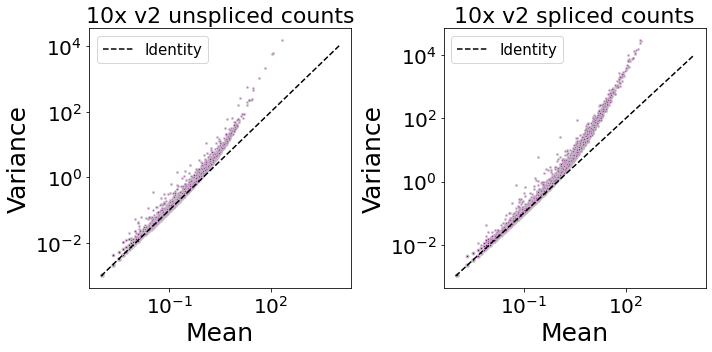

In [12]:
# mean vs variance

fig,ax = plt.subplots(1,2,figsize=(10,5))


ax[0].set_xlabel('Mean',fontsize=25)
ax[0].set_ylabel('Variance',fontsize=25)

ax[0].scatter(nd(adata.layers['unspliced'].mean(axis=0)),
              np.array(adata.layers['unspliced'].todense()).var(axis=0),
              s = 5, alpha = 0.5, edgecolor='lightgray',color='purple')
ax[0].set_title('10x v2 unspliced counts',fontsize=22)
ax[0].plot([0.001,10**4],[0.001,10**4],color='k',linestyle='--',label='Identity')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend(fontsize=15)


ax[1].set_xlabel('Mean',fontsize=25)
ax[1].set_ylabel('Variance',fontsize=25)

ax[1].scatter(nd(adata.layers['spliced'].mean(axis=0)),
              np.array(adata.layers['spliced'].todense()).var(axis=0),
              s = 5, alpha = 0.5, color = 'purple',edgecolor='lightgray')
ax[1].set_title('10x v2 spliced counts',fontsize=22)
ax[1].plot([0.001,10**4],[0.001,10**4],color='k',linestyle='--',label='Identity')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(fontsize=15)

plt.tight_layout();

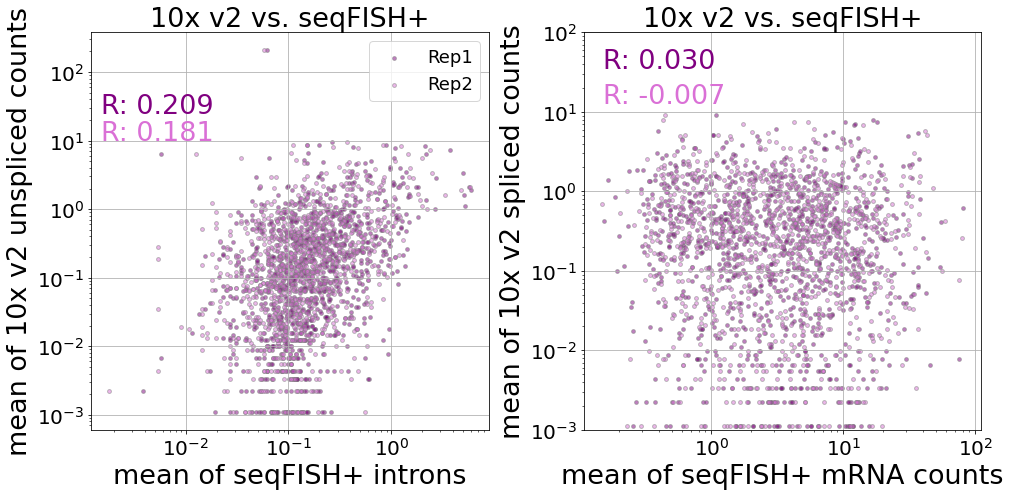

In [96]:
# intron vs exon means

color1 = 'purple'
color2 = 'orchid'
fs = 27
# show how empirical means correlate or don't for these many genes
colors = sns.color_palette("Paired")
eps = 1e-18
fig, ax = plt.subplots(1,2,figsize=(14,7))

######################################## RAW INTRONS
# correlation_,p = pearsonr(np.log(es_rep1_df_subset['mean_intron_counts'].values+eps),
#                           np.log(adata_df_subset['mean_unspliced_counts'].values+eps),
#                           )
# ax[0].scatter(es_rep1_df_subset['mean_intron_counts'].values,
#               adata_df_subset['mean_unspliced_counts'].values,
#               s=15,            
#               edgecolor='gray',
#               alpha=0.5,
#               label='Rep1',
#               color=color1)
# ax[0].annotate(f'R: {correlation_:.3f}',(0.15*10**-2,25),
#             fontsize=fs,color=color1)

# correlation_,p = pearsonr(np.log(es_rep2_df_subset['mean_intron_counts'].values+eps),
#                           np.log(adata_df_subset['mean_unspliced_counts'].values+eps),
#                           )
# ax[0].scatter(es_rep2_df_subset['mean_intron_counts'].values,
#               adata_df_subset['mean_unspliced_counts'].values,
#               s=15,            
#               edgecolor='gray',
#               alpha=0.5,
#               label='Rep2',
#               color=color2)
# ax[0].annotate(f'R: {correlation_:.3f}',(0.15*10**-2,10),
#             fontsize=fs,color=color2)

# ax[0].set_xlabel('seqFISH+ mean raw introns',fontsize=fs)
# ax[0].set_ylabel('Desai mean unspliced counts',fontsize=fs)
# ax[0].set_title(f'Unspliced/Raw introns',fontsize=fs)
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
# ax[0].legend(fontsize=18)
# ax[0].grid() 

######################################## ADJUSTED INTRONS
correlation_,p = pearsonr(np.log(es_rep1_df_subset['mean_adj_intron_counts'].values+eps),
                          np.log(adata_df_subset['mean_unspliced_counts'].values+eps),
                          )
ax[0].scatter(es_rep1_df_subset['mean_adj_intron_counts'].values,
              adata_df_subset['mean_unspliced_counts'].values,
              s=15,            
              edgecolor='gray',
              alpha=0.5,
              label='Rep1',
              color=color1)
ax[0].annotate(f'R: {correlation_:.3f}',(0.15*10**-2,25),
            fontsize=fs,color=color1)

correlation_,p = pearsonr(np.log(es_rep2_df_subset['mean_adj_intron_counts'].values+eps),
                          np.log(adata_df_subset['mean_unspliced_counts'].values+eps),
                          )
ax[0].scatter(es_rep2_df_subset['mean_adj_intron_counts'].values,
              adata_df_subset['mean_unspliced_counts'].values,
              s=15,            
              edgecolor='gray',
              alpha=0.5,
              label='Rep2',
              color=color2)
ax[0].annotate(f'R: {correlation_:.3f}',(0.15*10**-2,10),
            fontsize=fs,color=color2)

ax[0].set_xlabel('mean of seqFISH+ introns',fontsize=fs)
ax[0].set_ylabel('mean of 10x v2 unspliced counts',fontsize=fs)
ax[0].set_title(f'10x v2 vs. seqFISH+',fontsize=fs)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend(fontsize=18)
ax[0].grid() 
  
######################################## EXONS
correlation_,p = pearsonr(es_rep1_df_subset['mean_exon_counts'].values,
                          adata_df_subset['mean_spliced_counts'].values,
                          )
ax[1].scatter(es_rep1_df_subset['mean_exon_counts'].values,
              adata_df_subset['mean_spliced_counts'].values,
              s=15,
              edgecolor='gray',
              alpha=0.5,
              label='Rep1',
              color=color1)
ax[1].annotate(f'R: {correlation_:.3f}',(0.15,35),
            fontsize=fs,color=color1)

correlation_,p = pearsonr(es_rep2_df_subset['mean_exon_counts'].values,
                          adata_df_subset['mean_spliced_counts'].values,
                          )
ax[1].scatter(es_rep2_df_subset['mean_exon_counts'].values,
              adata_df_subset['mean_spliced_counts'].values,
              s=15,
              edgecolor='gray',
              alpha=0.5,
              label='Rep2',
              color=color2)
ax[1].annotate(f'R: {correlation_:.3f}',(.15,13),
            fontsize=fs,color=color2)

ax[1].set_ylim(0.7*10**-3,15)
#
ax[1].set_xlabel('mean of seqFISH+ mRNA counts',fontsize=fs)
ax[1].set_ylabel('mean of 10x v2 spliced counts',fontsize=fs)
ax[1].set_title(f'10x v2 vs. seqFISH+',fontsize=fs)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylim(10**-3,10**2)
ax[1].grid() 

plt.tight_layout();

# Fit *biVI* 



Fit *biVI* to Desai data and see how well correlated the burst sizes are.


Try to fit to all genes that had an observed burst sizes.

In [17]:
# load in parameters

with open(f'../results/biVI_Bursty_parameters_desai_overlap_genes','rb') as file:
        parameters = pickle.load(file)

In [18]:
# subset for mean
adata_s = adata[:,adata.var['gene_name'].isin(parameters['gene_name'])]
adata_s = adata_s[:,(nd(adata_s.layers['unspliced'].sum(axis=0))>.1) & (nd(adata_s.layers['spliced'].sum(axis=0))>.1)]

In [19]:
adata_s

View of AnnData object with n_obs × n_vars = 904 × 13064
    obs: 'barcode'
    var: 'gene_id', 'gene_name', 'ensembl_id_stripped'
    layers: 'matrix', 'spliced', 'unspliced'

Great, now fit *biVI* .

In [35]:
model_args = {    'n_latent'     : 10,
                  'n_layers'     : 3,
                  'dispersion'   : 'gene',
                  'n_hidden'     : 128,
                  'dropout_rate' :  0.1,
                  'log_variational'    :  True,
                  'latent_distribution':  'normal',
                  'THETA_IS' : 'NAS_SHAPE'
                  }

# training plan parameters
max_epochs = 400

plan_kwargs = {'lr' : 0.001,
               'n_epochs_kl_warmup' : max_epochs/2,
                }

In [36]:
# set up anndata for fitting
adata_spliced   = anndata.AnnData(adata_s.layers['spliced'])
adata_unspliced = anndata.AnnData(adata_s.layers['unspliced'])

adata_spliced.var = adata_s.var.copy()
adata_unspliced.var = adata_s.var.copy()
adata_spliced.var['Spliced']   = True
adata_unspliced.var['Spliced'] = False
adata_unspliced.var_names = adata_unspliced.var_names + '-u'

adata_fit = anndata.concat([adata_spliced,adata_unspliced],axis=1)
## Change AnnData expression to raw counts for negative binomial distribution
adata_fit.layers["counts"] = adata_fit.X.copy() # preserve counts

# Update obs,var
adata_fit.obs = adata_s.obs.copy()

In [34]:
biVI.biVI.setup_anndata(adata_fit,layer="counts")
    
model = biVI.biVI(adata_fit,mode='Bursty',**model_args)

{'n_input': 26128, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


In [35]:
adata_fit

AnnData object with n_obs × n_vars = 904 × 26128
    obs: 'barcode', '_scvi_batch', '_scvi_labels'
    var: 'gene_id', 'gene_name', 'ensembl_id_stripped', 'Spliced'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    layers: 'counts'

In [36]:
model.train(max_epochs = max_epochs,
                train_size = 0.9,
                check_val_every_n_epoch  = 1,
                plan_kwargs = plan_kwargs,
                batch_size=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 400/400: 100%|██████████| 400/400 [19:09<00:00,  2.85s/it, loss=1.78e+04, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [19:09<00:00,  2.87s/it, loss=1.78e+04, v_num=1]


In [ ]:
parameters = model.get_likelihood_parameters()

In [ ]:
# save inferred parameters!!!!!
parameters['gene_name'] = adata_s.var['gene_name']
parameters['gene_id'] = adata_s.var['ensembl_id_stripped']

with open(f'./results/biVI_Bursty_parameters_desai_overlap_genes','wb') as file:
        pickle.dump(parameters,file,protocol=pickle.HIGHEST_PROTOCOL)

# Compare parameters

In [72]:
# load in parameters

with open(f'../results/biVI_Bursty_parameters_desai_overlap_genes','rb') as file:
        parameters = pickle.load(file)

In [73]:
# subset one more time to only get unique genes? dont know why this did not work the first time

# unique_elements1, counts1 = np.unique(adata_s.var['gene_name'].values, return_counts=True)
# bad_gene = np.unique(adata_s.var['gene_name'].values)[counts1 > 1]

# filt1 = adata_s.var['gene_name'].values != bad_gene



biVI_df = pd.DataFrame({'burst_size' : parameters['burst_size'].mean(axis=0),
           'unspliced_means' : parameters['unspliced_means'].mean(axis=0),
           'spliced_means' : parameters['spliced_means'].mean(axis=0),
           'burst_size' : parameters['burst_size'].mean(axis=0),
           'burst_size_variance' : parameters['burst_size'].var(axis=0),
           'gene_name' : adata_s.var['gene_name'].values,
           'gene_id' : adata_s.var['ensembl_id_stripped'].values,
           'gene_name' : adata_s.var['gene_name'].values,
           })

In [74]:
es_rep1_df_all['gene_name_cat'] = pd.Categorical(
    es_rep1_df_all['gene_name'], 
    categories=np.sort(biVI_df['gene_name'].values), 
    ordered=True
)


es_rep2_df_all['gene_name_cat'] = pd.Categorical(
    es_rep2_df_all['gene_name'], 
    categories=np.sort(biVI_df['gene_name'].values), 
    ordered=True
)

biVI_df['gene_name_cat'] = pd.Categorical(
    biVI_df['gene_name'], 
    categories=np.sort(es_rep2_df_all['gene_name'].values), 
    ordered=True
)


biVI_df  = biVI_df.sort_values('gene_name_cat').dropna()
es_rep1_df_all  = es_rep1_df_all.sort_values('gene_name_cat').dropna()
es_rep2_df_all  = es_rep2_df_all.sort_values('gene_name_cat').dropna()


In [75]:
es_rep2_df_all

,gene_name,burst_size,burst_size_variance,gene_name_cat
8632,0610005C13Rik,0.061114,0.068976,0610005C13Rik
16886,0610009B22Rik,0.024548,0.031568,0610009B22Rik
6923,0610009L18Rik,0.062259,0.086451,0610009L18Rik
836,0610010F05Rik,0.127245,0.170022,0610010F05Rik
12837,0610040B10Rik,0.035678,0.037578,0610040B10Rik
...,...,...,...,...
1908,Zyx,0.076892,0.109577,Zyx
15803,Zzef1,0.029606,0.028426,Zzef1
1605,Zzz3,0.956723,1.081827,Zzz3
16510,a,0.027725,0.055468,a


In [76]:
# MARKER GENES from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6268870/


# es_MG = ['Pou5f1',
#         'Klf4',
#          'Nanog',
# #          'Zfx',
#          'Hmga2',
# #          'Stat3',
#          'Sall4',
#          'Lef1',
#          'Tcf3',
#          'Fbxo15']

es_MG = [
'Tcf3',
'Dppa4',
'Sall3']

epithelial_MG = [
'Krt18',
'Acta2',
'Tagln'
]

mg_filt = [mg in es_MG for mg in biVI_df['gene_name'].values]

epithelial_filt = [mg in epithelial_MG for mg in biVI_df['gene_name'].values]

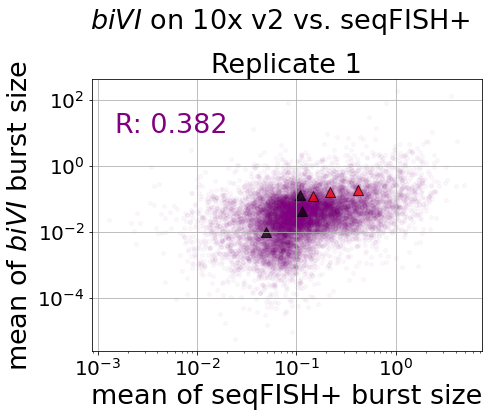

In [89]:
fs=27
save_path=None
fig,ax = plt.subplots(1,1,figsize=(7,5))
alpha = 0.03
edgecolor=None
contour_plot = False
if contour_plot == True:
    # Create a 2D histogram to calculate density
    x = es_rep2_df_all['burst_size']
    y = biVI_df['burst_size']
    hist, xedges, yedges = np.histogram2d(x, y, bins=(50, 50), density=True)

    # Create contour plot of density
    plt.contour(xedges[:-1], yedges[:-1], hist.T, levels=15, cmap='viridis')

    # Add a colorbar
    plt.colorbar(label='Density')
    
    
correlation_,p = pearsonr(np.log(es_rep1_df_all['burst_size']),
                          np.log(biVI_df['burst_size']))
plt.scatter(es_rep1_df_all['burst_size'],biVI_df['burst_size'],
            s=15,
            edgecolor=edgecolor,
            alpha=alpha,
            label='Rep1',
            color= color1)
ax.set_xlabel('mean of seqFISH+ burst size',fontsize=fs)
ax.set_ylabel('mean of $biVI$ burst size',fontsize=fs)
ax.set_title(f'Replicate 1',fontsize=fs)
plt.suptitle(f'$biVI$ on 10x v2 vs. seqFISH+',fontsize=fs, y = 1.08)
ax.set_xscale('log')
ax.set_yscale('log')
ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,10),
            fontsize=fs,color=color1)
#color=sns.color_palette()[0]
ax.grid('lightgray')

# correlation_,p = pearsonr(np.log(es_rep2_df_all['burst_size']),
#                           np.log(biVI_df['burst_size']))
# plt.scatter(es_rep2_df_all['burst_size'],biVI_df['burst_size'],
#             s=15,
#             edgecolor=edgecolor,
#             alpha=alpha,
#             label='Rep2',
#             color = color2)
# # ax[1].set_xlabel('seqFISH reported burstsize',fontsize=fs)
# # ax[1].set_ylabel('$biVI$ burstsize',fontsize=fs)
# # ax[1].set_title(f'E14 Rep2',fontsize=fs)
# # ax[1].set_xscale('log')
# # ax[1].set_yscale('log')
# ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,10),
#             fontsize=fs,color=color2)
# #color=sns.color_palette()[1]
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)



# scatter marker genes
plt.scatter(es_rep1_df_all['burst_size'][mg_filt],biVI_df['burst_size'][mg_filt],
            s=100,
            marker='^',
            edgecolor='black',
            alpha=0.7,
            color = 'red',
            label = 'mESC marker genes',
            )

# scatter marker genes
plt.scatter(es_rep1_df_all['burst_size'][epithelial_filt],biVI_df['burst_size'][epithelial_filt],
            s=100,
            marker='^',
            edgecolor='black',
            alpha=0.7,
            color = 'black',
            label = 'epithelial marker genes',
            )

# ax.legend(loc='lower right',fontsize=16,bbox_to_anchor=(1.67, .6))



if save_path:
    plt.savefig(save_path,dpi=300,bbox_inches='tight')

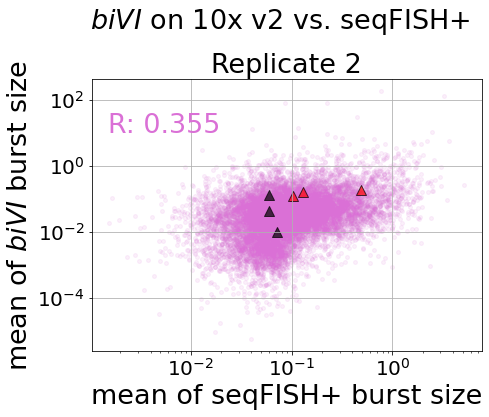

In [90]:
fs=27
save_path=None
fig,ax = plt.subplots(1,1,figsize=(7,5))
alpha = 0.1
edgecolor=None
contour_plot = False
if contour_plot == True:
    # Create a 2D histogram to calculate density
    x = es_rep2_df_all['burst_size']
    y = biVI_df['burst_size']
    hist, xedges, yedges = np.histogram2d(x, y, bins=(50, 50), density=True)

    # Create contour plot of density
    plt.contour(xedges[:-1], yedges[:-1], hist.T, levels=15, cmap='viridis')

    # Add a colorbar
    plt.colorbar(label='Density')
    
    
# correlation_,p = pearsonr(np.log(es_rep1_df_all['burst_size']),
#                           np.log(biVI_df['burst_size']))
# plt.scatter(es_rep1_df_all['burst_size'],biVI_df['burst_size'],
#             s=15,
#             edgecolor=edgecolor,
#             alpha=alpha,
#             label='Rep1',
#             color= color1)
# ax.set_xlabel('average seqFISH+ reported burst size',fontsize=fs)
# ax.set_ylabel('average $biVI$ burst size',fontsize=fs)
# ax.set_title(f'$biVI$ on Desai vs. seqFISH+',fontsize=fs)
ax.set_xlabel('mean of seqFISH+ burst size',fontsize=fs)
ax.set_ylabel('mean of $biVI$ burst size',fontsize=fs)
ax.set_title(f'Replicate 2',fontsize=fs)
plt.suptitle(f'$biVI$ on 10x v2 vs. seqFISH+',fontsize=fs, y = 1.08)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,50),
#             fontsize=fs,color=color1)
# #color=sns.color_palette()[0]
ax.grid('lightgray')

correlation_,p = pearsonr(np.log(es_rep2_df_all['burst_size']),
                          np.log(biVI_df['burst_size']))
plt.scatter(es_rep2_df_all['burst_size'],biVI_df['burst_size'],
            s=15,
            edgecolor=edgecolor,
            alpha=alpha,
            label='Rep2',
            color = color2)
# ax[1].set_xlabel('seqFISH reported burstsize',fontsize=fs)
# ax[1].set_ylabel('$biVI$ burstsize',fontsize=fs)
# ax[1].set_title(f'E14 Rep2',fontsize=fs)
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,10),
            fontsize=fs,color=color2)
#color=sns.color_palette()[1]
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



# scatter marker genes
plt.scatter(es_rep2_df_all['burst_size'][mg_filt],biVI_df['burst_size'][mg_filt],
            s=100,
            marker='^',
            edgecolor='black',
            alpha=0.7,
            color = 'red',
            label = 'mESC marker genes',
            )

# scatter marker genes
plt.scatter(es_rep2_df_all['burst_size'][epithelial_filt],biVI_df['burst_size'][epithelial_filt],
            s=100,
            marker='^',
            edgecolor='black',
            alpha=0.7,
            color = 'black',
            label = 'epithelial marker genes',
            )

# ax.legend(loc='lower right',fontsize=16,bbox_to_anchor=(1.67, .6))



if save_path:
    plt.savefig(save_path,dpi=300,bbox_inches='tight')

# Variance correlation

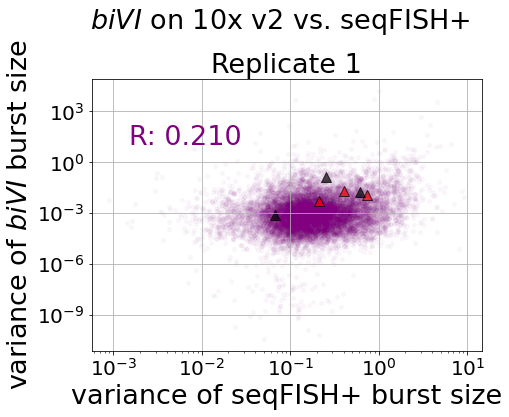

In [94]:
fs=27
save_path=None
fig,ax = plt.subplots(1,1,figsize=(7,5))
alpha = 0.03
edgecolor=None
contour_plot = False
if contour_plot == True:
    # Create a 2D histogram to calculate density
    x = es_rep2_df_all['burst_size_variance']
    y = biVI_df['burst_size']
    hist, xedges, yedges = np.histogram2d(x, y, bins=(50, 50), density=True)

    # Create contour plot of density
    plt.contour(xedges[:-1], yedges[:-1], hist.T, levels=15, cmap='viridis')

    # Add a colorbar
    plt.colorbar(label='Density')
    
    
correlation_,p = pearsonr(np.log(es_rep1_df_all['burst_size_variance']),
                          np.log(biVI_df['burst_size_variance']))
plt.scatter(es_rep1_df_all['burst_size_variance'],biVI_df['burst_size_variance'],
            s=15,
            edgecolor=edgecolor,
            alpha=alpha,
            label='Rep1',
            color= color1)


ax.set_xlabel('variance of seqFISH+ burst size',fontsize=fs)
ax.set_ylabel('variance of $biVI$ burst size',fontsize=fs)
ax.set_title(f'Replicate 1',fontsize=fs)
plt.suptitle(f'$biVI$ on 10x v2 vs. seqFISH+',fontsize=fs, y = 1.08)
ax.set_xscale('log')
ax.set_yscale('log')
ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,10),
            fontsize=fs,color=color1)
#color=sns.color_palette()[0]
ax.grid('lightgray')

# correlation_,p = pearsonr(np.log(es_rep2_df_all['burst_size_variance']),
#                           np.log(biVI_df['burst_size_variance']))
# plt.scatter(es_rep2_df_all['burst_size_variance'],biVI_df['burst_size_variance'],
#             s=15,
#             edgecolor=edgecolor,
#             alpha=alpha,
#             label='Rep2',
#             color = color2)
# # ax[1].set_xlabel('seqFISH reported burstsize',fontsize=fs)
# # ax[1].set_ylabel('$biVI$ burstsize',fontsize=fs)
# # ax[1].set_title(f'E14 Rep2',fontsize=fs)
# # ax[1].set_xscale('log')
# # ax[1].set_yscale('log')
# ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,10),
#             fontsize=fs,color=color2)
# #color=sns.color_palette()[1]
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)



# scatter marker genes
plt.scatter(es_rep1_df_all['burst_size_variance'][mg_filt],biVI_df['burst_size_variance'][mg_filt],
            s=100,
            marker='^',
            edgecolor='black',
            alpha=0.7,
            color = 'red',
            label = 'mESC marker genes',
            )

# scatter marker genes
plt.scatter(es_rep1_df_all['burst_size_variance'][epithelial_filt],biVI_df['burst_size_variance'][epithelial_filt],
            s=100,
            marker='^',
            edgecolor='black',
            alpha=0.7,
            color = 'black',
            label = 'epithelial marker genes',
            )

# ax.legend(loc='lower right',fontsize=16,bbox_to_anchor=(1.67, .6))



if save_path:
    plt.savefig(save_path,dpi=300,bbox_inches='tight')

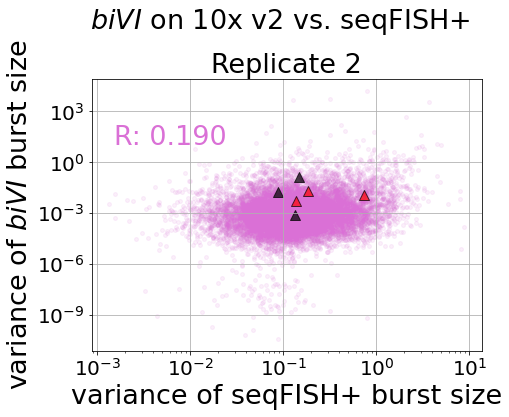

In [95]:
fs=27
save_path=None
fig,ax = plt.subplots(1,1,figsize=(7,5))
alpha = 0.1
edgecolor=None
contour_plot = False
if contour_plot == True:
    # Create a 2D histogram to calculate density
    x = es_rep2_df_all['burst_size_variance']
    y = biVI_df['burst_size']
    hist, xedges, yedges = np.histogram2d(x, y, bins=(50, 50), density=True)

    # Create contour plot of density
    plt.contour(xedges[:-1], yedges[:-1], hist.T, levels=15, cmap='viridis')

    # Add a colorbar
    plt.colorbar(label='Density')
    
    
# correlation_,p = pearsonr(np.log(es_rep1_df_all['burst_size']),
#                           np.log(biVI_df['burst_size']))
# plt.scatter(es_rep1_df_all['burst_size'],biVI_df['burst_size'],
#             s=15,
#             edgecolor=edgecolor,
#             alpha=alpha,
#             label='Rep1',
#             color= color1)
# ax.set_xlabel('average seqFISH+ reported burst size',fontsize=fs)
# ax.set_ylabel('average $biVI$ burst size',fontsize=fs)
# ax.set_title(f'$biVI$ on Desai vs. seqFISH+',fontsize=fs)
ax.set_xlabel('variance of seqFISH+ burst size',fontsize=fs)
ax.set_ylabel('variance of $biVI$ burst size',fontsize=fs)
ax.set_title(f'Replicate 2',fontsize=fs)
plt.suptitle(f'$biVI$ on 10x v2 vs. seqFISH+',fontsize=fs, y = 1.08)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,50),
#             fontsize=fs,color=color1)
# #color=sns.color_palette()[0]
ax.grid('lightgray')

correlation_,p = pearsonr(np.log(es_rep2_df_all['burst_size_variance']),
                          np.log(biVI_df['burst_size_variance']))
plt.scatter(es_rep2_df_all['burst_size_variance'],biVI_df['burst_size_variance'],
            s=15,
            edgecolor=edgecolor,
            alpha=alpha,
            label='Rep2',
            color = color2)
# ax[1].set_xlabel('seqFISH reported burstsize',fontsize=fs)
# ax[1].set_ylabel('$biVI$ burstsize',fontsize=fs)
# ax[1].set_title(f'E14 Rep2',fontsize=fs)
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,10),
            fontsize=fs,color=color2)
#color=sns.color_palette()[1]
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



# scatter marker genes
plt.scatter(es_rep2_df_all['burst_size_variance'][mg_filt],biVI_df['burst_size_variance'][mg_filt],
            s=100,
            marker='^',
            edgecolor='black',
            alpha=0.7,
            color = 'red',
            label = 'mESC marker genes',
            )

# scatter marker genes
plt.scatter(es_rep2_df_all['burst_size_variance'][epithelial_filt],biVI_df['burst_size_variance'][epithelial_filt],
            s=100,
            marker='^',
            edgecolor='black',
            alpha=0.7,
            color = 'black',
            label = 'epithelial marker genes',
            )

# ax.legend(loc='lower right',fontsize=16,bbox_to_anchor=(1.67, .6))



if save_path:
    plt.savefig(save_path,dpi=300,bbox_inches='tight')

In [78]:
print('Desai')
print('mESC marker genes:')
print(parameters['gene_name'].values[mg_filt])
print('avg seqFISH burstsize',es_rep1_df_all['burst_size'].values[mg_filt])
print('avg biVI burstsize',biVI_df['burst_size'].values[mg_filt])
print('---------')
print('epithelial marker genes:')
print(parameters['gene_name'].values[epithelial_filt])
print('avg seqFISH burstsize',es_rep1_df_all['burst_size'].values[epithelial_filt])
print('avg biVI burstsize',biVI_df['burst_size'].values[epithelial_filt])

Desai
mESC marker genes:
['Dsp' 'Pradc1' 'Syt3']
avg seqFISH burstsize [0.41902215 0.21621989 0.14643403]
avg biVI burstsize [0.18806353 0.1650042  0.11983269]
---------
epithelial marker genes:
['Gas5' 'Ubtd1' 'Il11']
avg seqFISH burstsize [0.04959656 0.10817591 0.11502964]
avg biVI burstsize [0.00990048 0.12826581 0.04443678]
